# I. Import module

In [1]:
# module for process data
import pandas as pd
import numpy as np

# module for visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import time

# module for machine learning
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

# II. Load csv files & Split data & Data Pre-processing)

## 1. NIR BenchMark Data (Without Pre-processing)
- BenchMark

In [5]:
# load NIR BenchMark data csv file
X = pd.read_csv("./NIR_Spectrum_data.csv")
X_data = X.values[:,2:]

# load y_data & wavelength csv file
y_data = X.values[0:,0]
y_data_class = X.values[0:,1]
wavelength = pd.read_csv("./wavelength.csv")
wavelength = wavelength.values[:,0:]

# to float32
X_data = np.asarray(X_data).astype('float32')
y_data = np.asarray(y_data).astype('float32')

# split X_data -> train, validation, test
X_train = X_data[0:249]
X_validation = X_data[249:397]
X_test = X_data[397:497]

# split y_data -> train, validation, test (4 categories in each data: 1 = Aluminium, 2 = Cardboard/Paper, 3 = HDPE, 4 = PET)
y_train = y_data[0:249]
y_validation = y_data[249:397]
y_test = y_data[397:497]

# split y_data_class -> train, validation, test (4 categories in each data: Aluminium, Cardboard/Paper, HDPE, PET)
y_train_class = y_data_class[0:249]
y_validation_class = y_data_class[249:397]
y_test_class = y_data_class[397:497]

# show data shape
print('Training data shape:',X_train.shape)
print('Validation data shape:',X_validation.shape)
print('Testing data shape:',X_test.shape)

Training data shape: (249, 124)
Validation data shape: (148, 124)
Testing data shape: (100, 124)


## 2. MSC Pre-processing Data
- MSC

In [3]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return (data_msc, ref)

Xmsc_data = msc(X_data)[0] # Take the first element of the output tuple

# split Xmsc_data -> train, validation, test
Xmsc_train = Xmsc_data[0:249]
Xmsc_validation = Xmsc_data[249:397]
Xmsc_test = Xmsc_data[397:497]

# show data shape
print('MSC Training data shape:',Xmsc_train.shape)
print('MSC Validation data shape:',Xmsc_validation.shape)
print('MSC Testing data shape:',Xmsc_test.shape)

MSC Training data shape: (249, 124)
MSC Validation data shape: (148, 124)
MSC Testing data shape: (100, 124)


## 3. NIR After SNV Pre-processing Data
- SNV

In [4]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

Xsnv_data = snv(X_data)

# split Xsnv_data -> train, validation, test
Xsnv_train = Xsnv_data[0:249]
Xsnv_validation = Xsnv_data[249:397]
Xsnv_test = Xsnv_data[397:497]

# show data shape
print('SNV Training data shape:',Xsnv_train.shape)
print('SNV Validation data shape:',Xsnv_validation.shape)
print('SNV Testing data shape:',Xsnv_test.shape)

SNV Training data shape: (249, 124)
SNV Validation data shape: (148, 124)
SNV Testing data shape: (100, 124)


# III. Visualize Spectrum Data

## 1. NIR BenchMark Data (Without Pre-processing)
- BenchMark

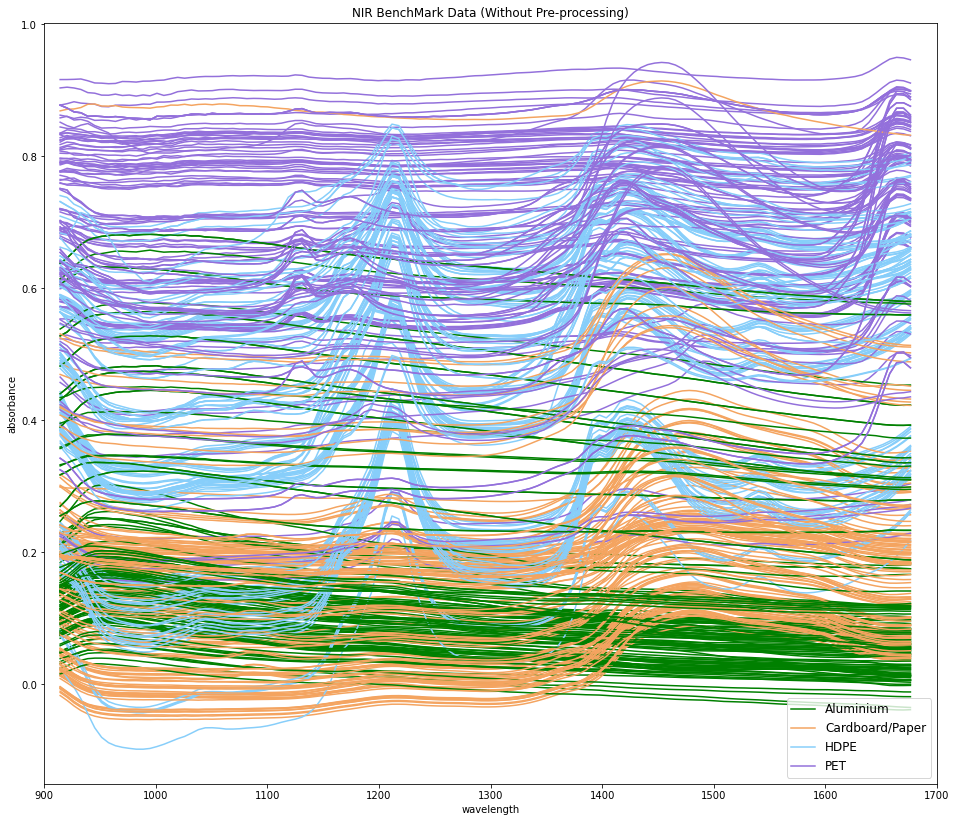

In [6]:
# Plot NIR BenchMark data
plt.figure(figsize=(16, 14))
plt.title('NIR BenchMark Data (Without Pre-processing)')
plt.xlabel('wavelength')
plt.ylabel('absorbance')
plt.xlim(900.0, 1700.0)

# set label & color for 4 categories: Aluminium, Cardboard/Paper, HDPE, PET
Aluminium, = plt.plot(wavelength, X_data[0], color="green")
Cardboard, = plt.plot(wavelength, X_data[63], color="sandybrown")
HDPE, = plt.plot(wavelength, X_data[126], color="lightskyblue")
PET, = plt.plot(wavelength, X_data[189], color="mediumpurple")

# plot X_train BenchMark data
for i in range(63):
    plt.plot(wavelength, X_data[i], color="green", label='Aluminium')
for i in range(63,126):
    plt.plot(wavelength, X_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(126,189):
    plt.plot(wavelength, X_data[i], color="lightskyblue", label='HDPE')
for i in range(189,249):
    plt.plot(wavelength, X_data[i], color="mediumpurple", label='PET')
    
# plot X_validation BenchMark data
for i in range(249,286):
    plt.plot(wavelength, X_data[i], color="green", label='Aluminium')
for i in range(286,323):
    plt.plot(wavelength, X_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(323,360):
    plt.plot(wavelength, X_data[i], color="lightskyblue", label='HDPE')
for i in range(360,397):
    plt.plot(wavelength, X_data[i], color="mediumpurple", label='PET')
    
# plot X_test BenchMark data
for i in range(397,422):
    plt.plot(wavelength, X_data[i], color="green", label='Aluminium')
for i in range(422,447):
    plt.plot(wavelength, X_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(447,472):
    plt.plot(wavelength, X_data[i], color="lightskyblue", label='HDPE')
for i in range(472,497):
    plt.plot(wavelength, X_data[i], color="mediumpurple", label='PET')

plt.legend([Aluminium, Cardboard, HDPE, PET], ["Aluminium", "Cardboard/Paper", "HDPE", "PET"], fontsize=12, loc='best')
# #plt.savefig('NIR BenchMark Data.png')

## 2. NIR After MSC Pre-processig Data
- MSC

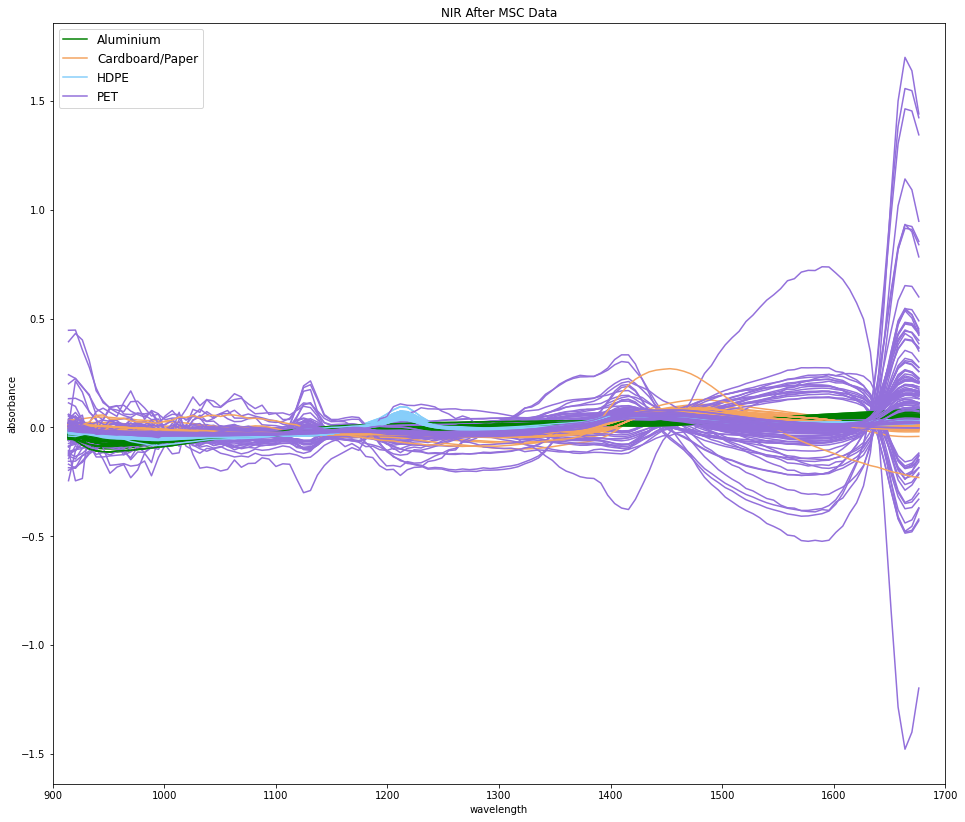

In [7]:
# Plot NIR MSC data
plt.figure(figsize=(16, 14))
plt.title('NIR After MSC Data')
plt.xlabel('wavelength')
plt.ylabel('absorbance')
plt.xlim(900.0, 1700.0)

# set label & color for 4 categories: Aluminium, Cardboard/Paper, HDPE, PET
Aluminium, = plt.plot(wavelength, Xmsc_data[0], color="green")
Cardboard, = plt.plot(wavelength, Xmsc_data[63], color="sandybrown")
HDPE, = plt.plot(wavelength, Xmsc_data[126], color="lightskyblue")
PET, = plt.plot(wavelength, Xmsc_data[189], color="mediumpurple")

# plot X_train MSC data
for i in range(63):
    plt.plot(wavelength, Xmsc_data[i], color="green", label='Aluminium')
for i in range(63,126):
    plt.plot(wavelength, Xmsc_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(126,189):
    plt.plot(wavelength, Xmsc_data[i], color="lightskyblue", label='HDPE')
for i in range(189,249):
    plt.plot(wavelength, Xmsc_data[i], color="mediumpurple", label='PET')
    
# plot X_validation MSC data
for i in range(249,286):
    plt.plot(wavelength, Xmsc_data[i], color="green", label='Aluminium')
for i in range(286,323):
    plt.plot(wavelength, Xmsc_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(323,360):
    plt.plot(wavelength, Xmsc_data[i], color="lightskyblue", label='HDPE')
for i in range(360,397):
    plt.plot(wavelength, Xmsc_data[i], color="mediumpurple", label='PET')
    
# plot X_test MSC data
for i in range(397,422):
    plt.plot(wavelength, Xmsc_data[i], color="green", label='Aluminium')
for i in range(422,447):
    plt.plot(wavelength, Xmsc_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(447,472):
    plt.plot(wavelength, Xmsc_data[i], color="lightskyblue", label='HDPE')
for i in range(472,497):
    plt.plot(wavelength, Xmsc_data[i], color="mediumpurple", label='PET')

plt.legend([Aluminium, Cardboard, HDPE, PET], ["Aluminium", "Cardboard/Paper", "HDPE", "PET"], fontsize=12, loc='best')
# #plt.savefig('NIR MSC Data.png')

## 3. NIR After SNV Pre-processig Data
- SNV

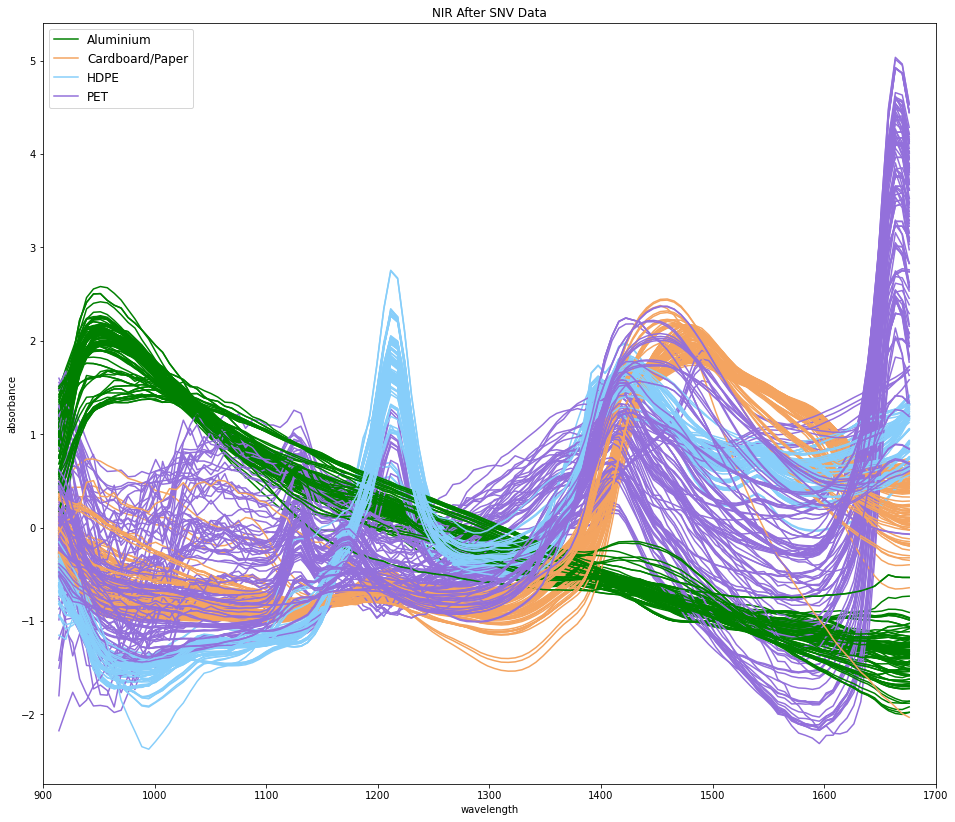

In [8]:
# Plot NIR SNV data
plt.figure(figsize=(16, 14))
plt.title('NIR After SNV Data')
plt.xlabel('wavelength')
plt.ylabel('absorbance')
plt.xlim(900.0, 1700.0)

# set label & color for 4 categories: Aluminium, Cardboard/Paper, HDPE, PET
Aluminium, = plt.plot(wavelength, Xsnv_data[0], color="green")
Cardboard, = plt.plot(wavelength, Xsnv_data[63], color="sandybrown")
HDPE, = plt.plot(wavelength, Xsnv_data[126], color="lightskyblue")
PET, = plt.plot(wavelength, Xsnv_data[189], color="mediumpurple")

# plot X_train SNV data
for i in range(63):
    plt.plot(wavelength, Xsnv_data[i], color="green", label='Aluminium')
for i in range(63,126):
    plt.plot(wavelength, Xsnv_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(126,189):
    plt.plot(wavelength, Xsnv_data[i], color="lightskyblue", label='HDPE')
for i in range(189,249):
    plt.plot(wavelength, Xsnv_data[i], color="mediumpurple", label='PET')
    
# plot X_validation SNV data
for i in range(249,286):
    plt.plot(wavelength, Xsnv_data[i], color="green", label='Aluminium')
for i in range(286,323):
    plt.plot(wavelength, Xsnv_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(323,360):
    plt.plot(wavelength, Xsnv_data[i], color="lightskyblue", label='HDPE')
for i in range(360,397):
    plt.plot(wavelength, Xsnv_data[i], color="mediumpurple", label='PET')
    
# plot X_test SNV data
for i in range(397,422):
    plt.plot(wavelength, Xsnv_data[i], color="green", label='Aluminium')
for i in range(422,447):
    plt.plot(wavelength, Xsnv_data[i], color="sandybrown", label='Cardboard/Paper')
for i in range(447,472):
    plt.plot(wavelength, Xsnv_data[i], color="lightskyblue", label='HDPE')
for i in range(472,497):
    plt.plot(wavelength, Xsnv_data[i], color="mediumpurple", label='PET')

plt.legend([Aluminium, Cardboard, HDPE, PET], ["Aluminium", "Cardboard/Paper", "HDPE", "PET"], fontsize=12, loc='best')
# #plt.savefig('NIR SNV Data.png')

# IV. Classification

# 1. Machine Learning

## 1.1. SVM (Support Vector Machine)

### SVM - Linear kernel
- BenchMark - confusion matrix

NIR BenchMark Data Training time: 0.3968384265899658s
SVM (linear kernel)'s accuracy on BenchMark data training set is 98.39%
SVM (linear kernel)'s accuracy on BenchMark data validation set is 97.30%
SVM (linear kernel)'s accuracy on BenchMark data test set is 89.00%
-----------------------------------------------------------------
SVM (linear kernel) classification on [NIR BenchMark data test set] report: 

                 precision    recall  f1-score   support

      Aluminium       1.00      0.92      0.96        25
Cardboard/Paper       0.75      0.96      0.84        25
           HDPE       1.00      1.00      1.00        25
            PET       0.85      0.68      0.76        25

       accuracy                           0.89       100
      macro avg       0.90      0.89      0.89       100
   weighted avg       0.90      0.89      0.89       100



D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


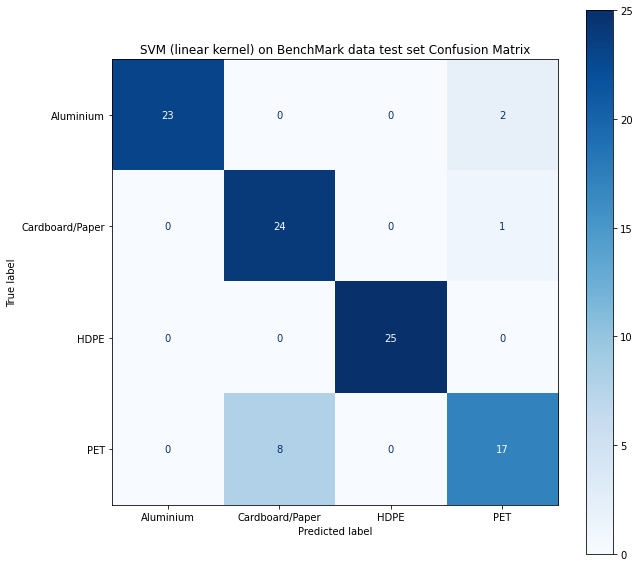

-----------------------------------------------------------------
SVM (linear kernel) classification on [NIR BenchMark data validation set] report: 

                 precision    recall  f1-score   support

      Aluminium       1.00      0.95      0.97        37
Cardboard/Paper       0.95      1.00      0.97        37
           HDPE       1.00      1.00      1.00        37
            PET       0.95      0.95      0.95        37

       accuracy                           0.97       148
      macro avg       0.97      0.97      0.97       148
   weighted avg       0.97      0.97      0.97       148



D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


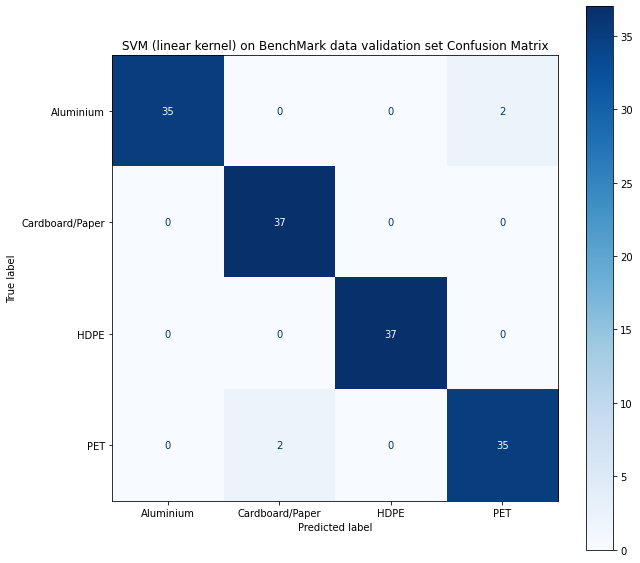

In [9]:
# build SVM Linear kernel model
SVMLinearModel=svm.LinearSVC(max_iter=10000)
SVMLinearModel = CalibratedClassifierCV(SVMLinearModel)

# -----training "NIR BenchMark data" using SVM Linear kernel model, also calculate training time-----
start = time.time()
SVMLinearModel1 = SVMLinearModel.fit(X_train, y_train_class.ravel()) # there using y_train_class, so we can see the label name on the Confusion Matrix
stop = time.time()
print(f"NIR BenchMark Data Training time: {stop - start}s")

print(f'SVM (linear kernel)\'s accuracy on BenchMark data training set is {100 * SVMLinearModel1.score(X_train, y_train_class):.2f}%')
print(f'SVM (linear kernel)\'s accuracy on BenchMark data validation set is {100 * SVMLinearModel1.score(X_validation, y_validation_class):.2f}%')
print(f'SVM (linear kernel)\'s accuracy on BenchMark data test set is {100 * SVMLinearModel1.score(X_test, y_test_class):.2f}%')
print('-----------------------------------------------------------------')

# predicting the "NIR BenchMark data" Test set results
y_predTest1 = SVMLinearModel1.predict(X_test)
# show precision, recall, accuracy, F-score evaluation metrics
print("SVM (linear kernel) classification on [NIR BenchMark data test set] report: \n")
print(classification_report(y_test_class, y_predTest1))

# Making the Confusion Matrix of the SVM Linear kernel model on test set
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(SVMLinearModel1, X_test, y_test_class, cmap = plt.cm.Blues, ax = ax).ax_.set_title('SVM (linear kernel) on BenchMark data test set Confusion Matrix')
plt.show()
print('-----------------------------------------------------------------')


# predicting the "NIR BenchMark data" Validation set results
y_predVal1 = SVMLinearModel1.predict(X_validation)
# show precision, recall, accuracy, F-score evaluation metrics
print("SVM (linear kernel) classification on [NIR BenchMark data validation set] report: \n")
print(classification_report(y_validation_class, y_predVal1))
# Making the Confusion Matrix of the SVM Linear kernel model on validation set
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(SVMLinearModel1, X_validation, y_validation_class, cmap = plt.cm.Blues, ax = ax).ax_.set_title('SVM (linear kernel) on BenchMark data validation set Confusion Matrix')
plt.show()

### SVM - Sigmoid kernel
- BenchMark - confusion matrix

NIR BenchMark Data Training time: 0.038063764572143555s
SVM (sigmoid kernel)'s accuracy on BenchMark data training set is 65.86%
SVM (sigmoid kernel)'s accuracy on BenchMark data validation set is 61.49%
SVM (sigmoid kernel)'s accuracy on BenchMark data test set is 39.00%
-----------------------------------------------------------------
SVM (Sigmoid kernel) classification on [NIR BenchMark data test set] report: 

                 precision    recall  f1-score   support

      Aluminium       1.00      0.40      0.57        25
Cardboard/Paper       0.33      0.16      0.22        25
           HDPE       0.16      0.24      0.19        25
            PET       0.47      0.76      0.58        25

       accuracy                           0.39       100
      macro avg       0.49      0.39      0.39       100
   weighted avg       0.49      0.39      0.39       100



D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


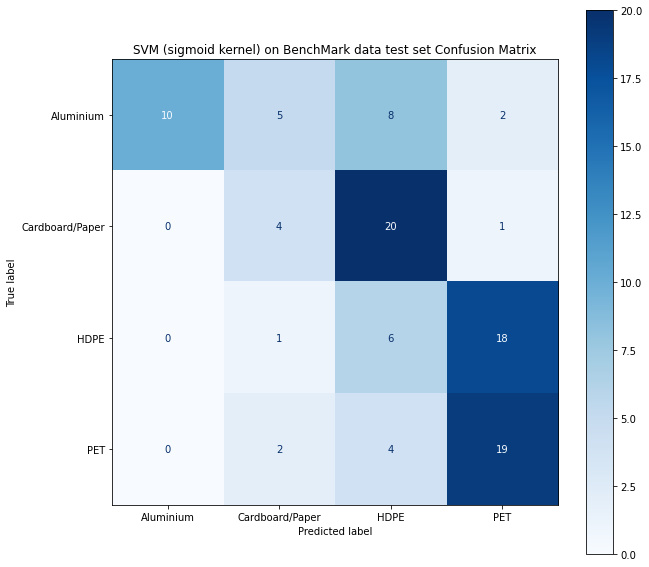

-----------------------------------------------------------------
SVM (Sigmoid kernel) classification on [NIR BenchMark data validation set] report: 

                 precision    recall  f1-score   support

      Aluminium       0.84      0.86      0.85        37
Cardboard/Paper       0.44      0.11      0.17        37
           HDPE       0.47      0.78      0.59        37
            PET       0.67      0.70      0.68        37

       accuracy                           0.61       148
      macro avg       0.61      0.61      0.57       148
   weighted avg       0.61      0.61      0.57       148



D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


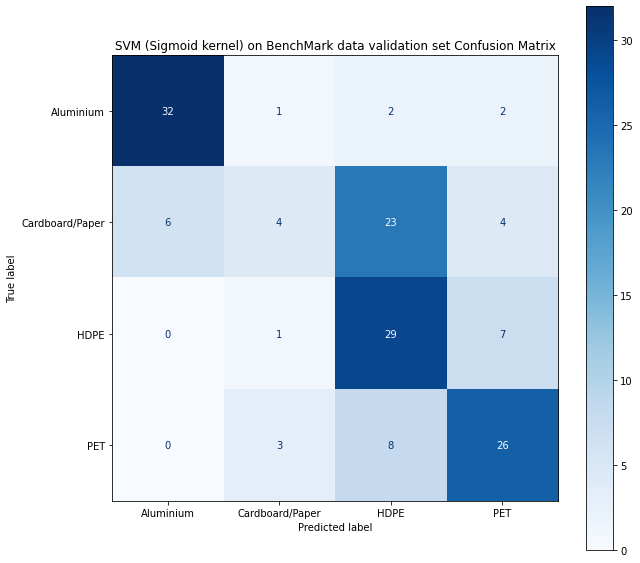

In [35]:
# build SVM Sigmoid kernel model
SVMSigmoidModel=svm.SVC(kernel='sigmoid')
SVMSigmoidModel = CalibratedClassifierCV(SVMSigmoidModel)

# -----training "NIR BenchMark data" using SVM Sigmoid kernel model, also calculate training time-----
start = time.time()
SVMSigmoidModel1 = SVMSigmoidModel.fit(X_train, y_train_class.ravel()) # there using y_train_class, so we can see the label name on the Confusion Matrix
stop = time.time()
print(f"NIR BenchMark Data Training time: {stop - start}s")

print(f'SVM (sigmoid kernel)\'s accuracy on BenchMark data training set is {100 * SVMSigmoidModel1.score(X_train, y_train_class):.2f}%')
print(f'SVM (sigmoid kernel)\'s accuracy on BenchMark data validation set is {100 * SVMSigmoidModel1.score(X_validation, y_validation_class):.2f}%')
print(f'SVM (sigmoid kernel)\'s accuracy on BenchMark data test set is {100 * SVMSigmoidModel1.score(X_test, y_test_class):.2f}%')
print('-----------------------------------------------------------------')

# predicting the "NIR BenchMark data" Test set results
y_predTest1 = SVMSigmoidModel1.predict(X_test)
# show precision, recall, accuracy, F-score evaluation metrics
print("SVM (Sigmoid kernel) classification on [NIR BenchMark data test set] report: \n")
print(classification_report(y_test_class, y_predTest1))

# Making the Confusion Matrix of the SVM Sigmoid kernel model on test set
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(SVMSigmoidModel1, X_test, y_test_class, cmap = plt.cm.Blues, ax = ax).ax_.set_title('SVM (sigmoid kernel) on BenchMark data test set Confusion Matrix')
plt.show()
print('-----------------------------------------------------------------')


# predicting the "NIR BenchMark data" Validation set results
y_predVal1 = SVMSigmoidModel1.predict(X_validation)
# show precision, recall, accuracy, F-score evaluation metrics
print("SVM (Sigmoid kernel) classification on [NIR BenchMark data validation set] report: \n")
print(classification_report(y_validation_class, y_predVal1))
# Making the Confusion Matrix of the SVM Sigmoid kernel model on validation set
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(SVMSigmoidModel1, X_validation, y_validation_class, cmap = plt.cm.Blues, ax = ax).ax_.set_title('SVM (Sigmoid kernel) on BenchMark data validation set Confusion Matrix')
plt.show()

# 2. Deep Learning

## 2.1. SGD Optimizer

- BenchMark - build model

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_validation = scaler.transform(X_validation)
Xs_test = scaler.transform(X_test)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xs_train, y_train, epochs=100, \
            validation_data=(Xs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xs_train, y_train, epochs=100, \
            validation_data=(Xs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 2s 30ms/step - loss: 2.0170 - accuracy: 0.4217 - val_loss: 1.7656 - val_accuracy: 0.6419
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 1.6475 - accuracy: 0.7269 - val_loss: 1.5394 - val_accuracy: 0.7027
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.4477 - accuracy: 0.8072 - val_loss: 1.3801 - val_accuracy: 0.7635
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 1.2954 - accuracy: 0.8153 - val_loss: 1.2519 - val_accuracy: 0.7905
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 1.1733 - accuracy: 0.8594 - val_loss: 1.1472 - val_accuracy: 0.8446
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0734 - accuracy: 0.8755 - val_loss: 1.0589 - val_accuracy: 0.8446
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.9855 - accuracy: 0.8795 - val_loss: 0.9813 - val_accuracy: 0.8446
Epoch 8/100
8/8 [=========

8/8 [==============================] - 0s 6ms/step - loss: 0.1906 - accuracy: 0.9759 - val_loss: 0.2193 - val_accuracy: 0.9527
Epoch 60/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1856 - accuracy: 0.9759 - val_loss: 0.2188 - val_accuracy: 0.9459
Epoch 61/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1833 - accuracy: 0.9759 - val_loss: 0.2191 - val_accuracy: 0.9459
Epoch 62/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1833 - accuracy: 0.9679 - val_loss: 0.2124 - val_accuracy: 0.9527
Epoch 63/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1811 - accuracy: 0.9719 - val_loss: 0.2063 - val_accuracy: 0.9595
Epoch 64/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1786 - accuracy: 0.9759 - val_loss: 0.2109 - val_accuracy: 0.9527
Epoch 65/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1787 - accuracy: 0.9719 - val_loss: 0.2088 - val_accuracy: 0.9527
Epoch 66/100
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.5676 - accuracy: 0.8795 - val_loss: 0.6767 - val_accuracy: 0.8176
Epoch 18/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5488 - accuracy: 0.8675 - val_loss: 0.6580 - val_accuracy: 0.8243
Epoch 19/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5234 - accuracy: 0.8554 - val_loss: 0.6334 - val_accuracy: 0.8311
Epoch 20/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5063 - accuracy: 0.8755 - val_loss: 0.6140 - val_accuracy: 0.8446
Epoch 21/100
8/8 [==============================] - 0s 6ms/step - loss: 0.4822 - accuracy: 0.8916 - val_loss: 0.5974 - val_accuracy: 0.8243
Epoch 22/100
8/8 [==============================] - 0s 8ms/step - loss: 0.4692 - accuracy: 0.8715 - val_loss: 0.5796 - val_accuracy: 0.8716
Epoch 23/100
8/8 [==============================] - 0s 7ms/step - loss: 0.4504 - accuracy: 0.8996 - val_loss: 0.5551 - val_accuracy: 0.8176
Epoch 24/100
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.1454 - accuracy: 0.9598 - val_loss: 0.2164 - val_accuracy: 0.9122
Epoch 76/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1422 - accuracy: 0.9598 - val_loss: 0.2137 - val_accuracy: 0.9122
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1433 - accuracy: 0.9639 - val_loss: 0.2141 - val_accuracy: 0.9189
Epoch 78/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1406 - accuracy: 0.9598 - val_loss: 0.2128 - val_accuracy: 0.9189
Epoch 79/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1359 - accuracy: 0.9639 - val_loss: 0.2107 - val_accuracy: 0.9189
Epoch 80/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1479 - accuracy: 0.9558 - val_loss: 0.2115 - val_accuracy: 0.9189
Epoch 81/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1346 - accuracy: 0.9639 - val_loss: 0.2057 - val_accuracy: 0.9122
Epoch 82/100
8/8 [===============

- BenchMark - plot loss and acc

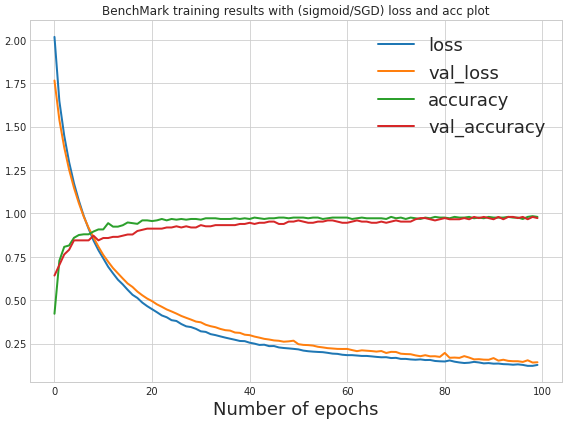

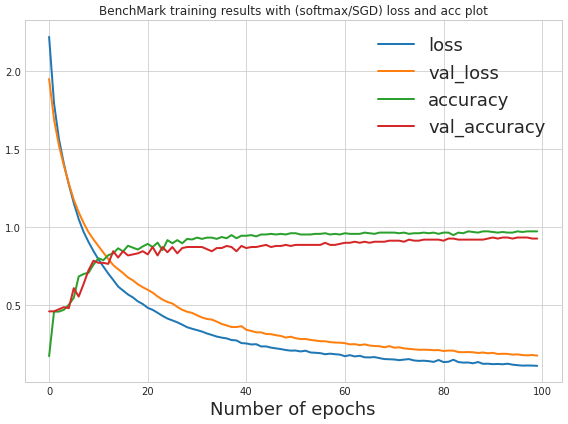

In [11]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('BenchMark training results with (sigmoid/SGD) loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('BenchMark training results with (softmax/SGD) loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- BenchMark - report

In [12]:
pred_train = model1.predict(Xs_train)
scores = model1.evaluate(Xs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid/SGD) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xs_test)
scores2 = model1.evaluate(Xs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid/SGD) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xs_train)
scores = model2.evaluate(Xs_train, y_train, verbose = 0)
print("Accuracy on (softmax/SGD) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xs_test)
scores2 = model2.evaluate(Xs_test, y_test, verbose = 0)
print("Accuracy on (softmax/SGD) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 1ms/step
Accuracy on (sigmoid/SGD) train data: 0.9799196720123291% 
 Error on train data: 0.0200803279876709
4/4 [==============================] - 0s 2ms/step
Accuracy on (sigmoid/SGD) test data: 0.8100000023841858% 
 Error on test data: 0.1899999976158142
-----------------------------------------------------------------
8/8 [==============================] - 0s 2ms/step
Accuracy on (softmax/SGD) train data: 0.9678714871406555% 
 Error on train data: 0.03212851285934448
4/4 [==============================] - 0s 1ms/step
Accuracy on (softmax/SGD) test data: 0.7400000095367432% 
 Error on test data: 0.25999999046325684


- BenchMark - confusion matrix

4/4 [==============================] - 0s 2ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


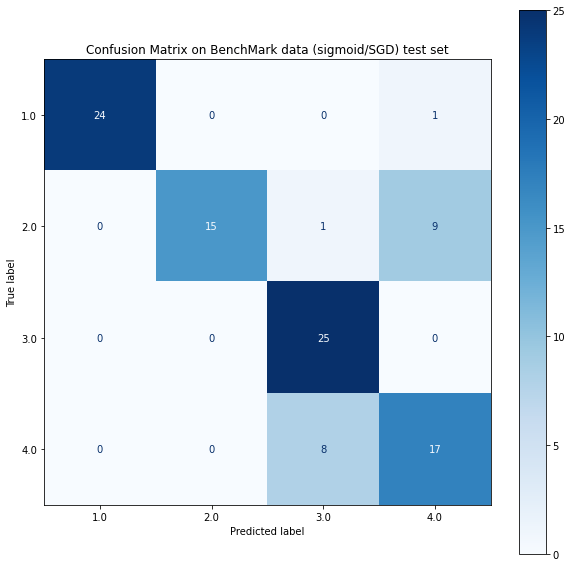

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4/4 [==============================] - 0s 2ms/step


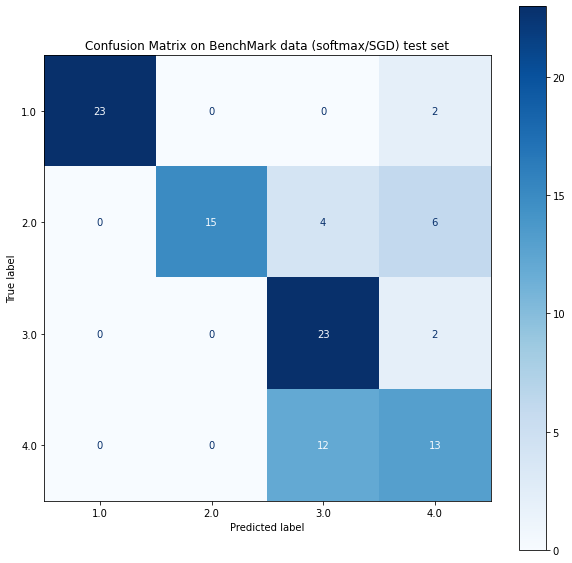

In [13]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on BenchMark data (sigmoid/SGD) test set')
# plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on BenchMark data (softmax/SGD) test set')
# plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

- MSC - build model

In [14]:
scaler = StandardScaler()
scaler.fit(Xmsc_train)
Xmscs_train = scaler.transform(Xmsc_train)
Xmscs_validation = scaler.transform(Xmsc_validation)
Xmscs_test = scaler.transform(Xmsc_test)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xmscs_train, y_train, epochs=100, \
            validation_data=(Xmscs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xmscs_train, y_train, epochs=100, \
            validation_data=(Xmscs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 30ms/step - loss: 2.0384 - accuracy: 0.3614 - val_loss: 1.6017 - val_accuracy: 0.7568
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 1.4350 - accuracy: 0.8032 - val_loss: 1.2972 - val_accuracy: 0.7770
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 1.1915 - accuracy: 0.8514 - val_loss: 1.1285 - val_accuracy: 0.8176
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 1.0416 - accuracy: 0.8755 - val_loss: 1.0142 - val_accuracy: 0.8378
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.9370 - accuracy: 0.8876 - val_loss: 0.9297 - val_accuracy: 0.8649
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8584 - accuracy: 0.8876 - val_loss: 0.8645 - val_accuracy: 0.8649
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.7956 - accuracy: 0.8876 - val_loss: 0.8119 - val_accuracy: 0.8649
Epoch 8/100
8/8 [========

8/8 [==============================] - 0s 8ms/step - loss: 0.1472 - accuracy: 0.9839 - val_loss: 0.1793 - val_accuracy: 0.9595
Epoch 60/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1435 - accuracy: 0.9839 - val_loss: 0.1756 - val_accuracy: 0.9595
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1400 - accuracy: 0.9839 - val_loss: 0.1724 - val_accuracy: 0.9595
Epoch 62/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1367 - accuracy: 0.9839 - val_loss: 0.1693 - val_accuracy: 0.9595
Epoch 63/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1333 - accuracy: 0.9839 - val_loss: 0.1659 - val_accuracy: 0.9595
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1302 - accuracy: 0.9839 - val_loss: 0.1634 - val_accuracy: 0.9595
Epoch 65/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1270 - accuracy: 0.9839 - val_loss: 0.1607 - val_accuracy: 0.9595
Epoch 66/100
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.3229 - accuracy: 0.9679 - val_loss: 0.3043 - val_accuracy: 0.9662
Epoch 18/100
8/8 [==============================] - 0s 7ms/step - loss: 0.2832 - accuracy: 0.9719 - val_loss: 0.2683 - val_accuracy: 0.9662
Epoch 19/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2496 - accuracy: 0.9759 - val_loss: 0.2380 - val_accuracy: 0.9730
Epoch 20/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2217 - accuracy: 0.9799 - val_loss: 0.2127 - val_accuracy: 0.9730
Epoch 21/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1981 - accuracy: 0.9799 - val_loss: 0.1920 - val_accuracy: 0.9730
Epoch 22/100
8/8 [==============================] - 0s 6ms/step - loss: 0.1790 - accuracy: 0.9799 - val_loss: 0.1750 - val_accuracy: 0.9730
Epoch 23/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1632 - accuracy: 0.9799 - val_loss: 0.1603 - val_accuracy: 0.9730
Epoch 24/100
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 76/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 1.0000
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 78/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0253 - accuracy: 1.0000 - val_loss: 0.0257 - val_accuracy: 1.0000
Epoch 79/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 80/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 81/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 1.0000
Epoch 82/100
8/8 [===============

- MSC - plot loss and acc

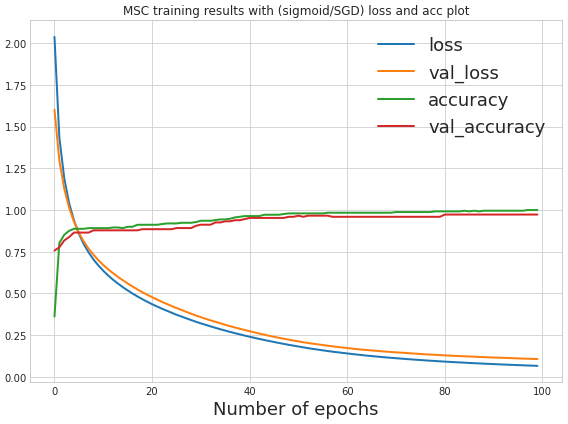

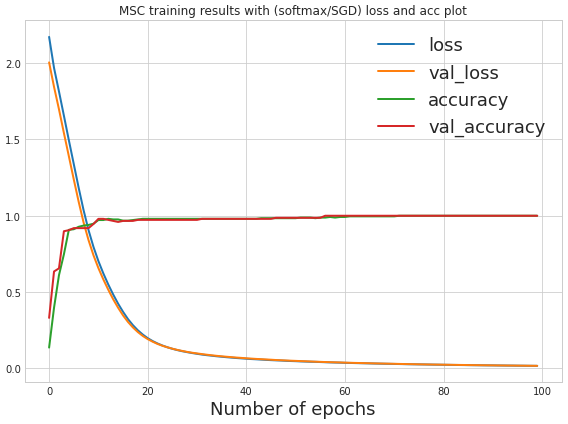

In [15]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('MSC training results with (sigmoid/SGD) loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('MSC training results with (softmax/SGD) loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- MSC - report

In [16]:
pred_train = model1.predict(Xmscs_train)
scores = model1.evaluate(Xmscs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid/SGD) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xmscs_test)
scores2 = model1.evaluate(Xmscs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid/SGD) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xmscs_train)
scores = model2.evaluate(Xmscs_train, y_train, verbose = 0)
print("Accuracy on (softmax/SGD) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xmscs_test)
scores2 = model2.evaluate(Xmscs_test, y_test, verbose = 0)
print("Accuracy on (softmax/SGD) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 2ms/step
Accuracy on (sigmoid/SGD) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 2ms/step
Accuracy on (sigmoid/SGD) test data: 0.9100000262260437% 
 Error on test data: 0.0899999737739563
-----------------------------------------------------------------
8/8 [==============================] - 0s 2ms/step
Accuracy on (softmax/SGD) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 2ms/step
Accuracy on (softmax/SGD) test data: 0.9399999976158142% 
 Error on test data: 0.06000000238418579


- MSC - confusion matrix

4/4 [==============================] - 0s 2ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


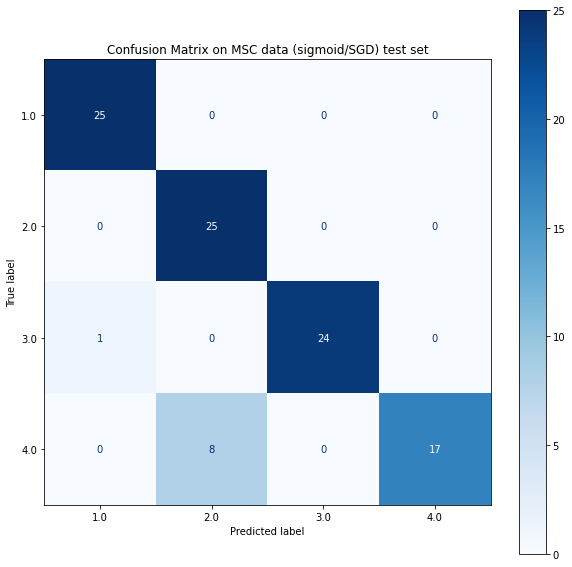

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4/4 [==============================] - 0s 2ms/step


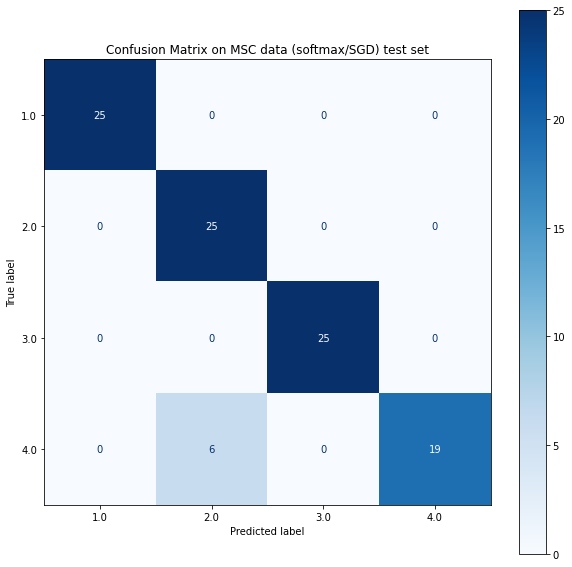

In [17]:
classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (sigmoid/SGD) test set')
# plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (softmax/SGD) test set')
# plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

- SNV - build model

In [18]:
scaler = StandardScaler()
scaler.fit(Xsnv_train)
Xsnvs_train = scaler.transform(Xsnv_train)
Xsnvs_validation = scaler.transform(Xsnv_validation)
Xsnvs_test = scaler.transform(Xsnv_test)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xsnvs_train, y_train, epochs=100, \
            validation_data=(Xsnvs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xsnvs_train, y_train, epochs=100, \
            validation_data=(Xsnvs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 28ms/step - loss: 1.8422 - accuracy: 0.4980 - val_loss: 1.4901 - val_accuracy: 0.7365
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 1.2951 - accuracy: 0.8474 - val_loss: 1.1349 - val_accuracy: 0.8716
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 1.0198 - accuracy: 0.9076 - val_loss: 0.9356 - val_accuracy: 0.9122
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.8535 - accuracy: 0.9357 - val_loss: 0.8045 - val_accuracy: 0.9459
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.7400 - accuracy: 0.9558 - val_loss: 0.7080 - val_accuracy: 0.9527
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.6549 - accuracy: 0.9639 - val_loss: 0.6342 - val_accuracy: 0.9527
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.5886 - accuracy: 0.9679 - val_loss: 0.5743 - val_accuracy: 0.9595
Epoch 8/100
8/8 [=========

8/8 [==============================] - 0s 6ms/step - loss: 0.0782 - accuracy: 0.9920 - val_loss: 0.0753 - val_accuracy: 1.0000
Epoch 60/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0766 - accuracy: 0.9960 - val_loss: 0.0738 - val_accuracy: 1.0000
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0752 - accuracy: 0.9920 - val_loss: 0.0724 - val_accuracy: 1.0000
Epoch 62/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0736 - accuracy: 0.9960 - val_loss: 0.0710 - val_accuracy: 1.0000
Epoch 63/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0723 - accuracy: 0.9960 - val_loss: 0.0697 - val_accuracy: 1.0000
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0710 - accuracy: 0.9960 - val_loss: 0.0684 - val_accuracy: 1.0000
Epoch 65/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0697 - accuracy: 0.9960 - val_loss: 0.0672 - val_accuracy: 1.0000
Epoch 66/100
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0992 - accuracy: 0.9880 - val_loss: 0.0928 - val_accuracy: 0.9932
Epoch 18/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0881 - accuracy: 0.9960 - val_loss: 0.0828 - val_accuracy: 0.9932
Epoch 19/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0795 - accuracy: 0.9960 - val_loss: 0.0746 - val_accuracy: 1.0000
Epoch 20/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0721 - accuracy: 0.9960 - val_loss: 0.0674 - val_accuracy: 1.0000
Epoch 21/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0650 - accuracy: 0.9960 - val_loss: 0.0616 - val_accuracy: 1.0000
Epoch 22/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0595 - accuracy: 0.9960 - val_loss: 0.0567 - val_accuracy: 1.0000
Epoch 23/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0549 - accuracy: 1.0000 - val_loss: 0.0524 - val_accuracy: 1.0000
Epoch 24/100
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 76/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 77/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 78/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 79/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 80/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 81/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 82/100
8/8 [===============

- SNV - plot loss and acc

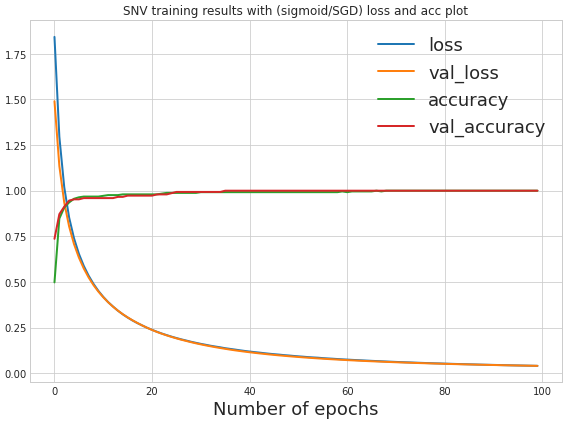

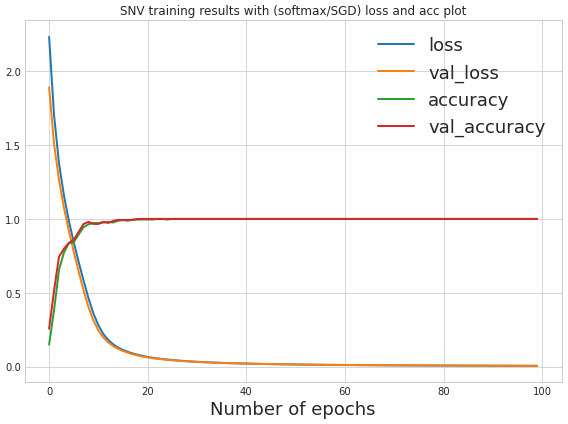

In [19]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('SNV training results with (sigmoid/SGD) loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('SNV training results with (softmax/SGD) loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- SNV - report

In [20]:
pred_train = model1.predict(Xsnvs_train)
scores = model1.evaluate(Xsnvs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid/SGD) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xsnvs_test)
scores2 = model1.evaluate(Xsnvs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid/SGD) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xsnvs_train)
scores = model2.evaluate(Xsnvs_train, y_train, verbose = 0)
print("Accuracy on (softmax/SGD) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xsnvs_test)
scores2 = model2.evaluate(Xsnvs_test, y_test, verbose = 0)
print("Accuracy on (softmax/SGD) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 1ms/step
Accuracy on (sigmoid/SGD) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 1ms/step
Accuracy on (sigmoid/SGD) test data: 0.9599999785423279% 
 Error on test data: 0.04000002145767212
-----------------------------------------------------------------
8/8 [==============================] - 0s 1ms/step
Accuracy on (softmax/SGD) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 1ms/step
Accuracy on (softmax/SGD) test data: 0.9599999785423279% 
 Error on test data: 0.04000002145767212


- SNV - confusion matrix

4/4 [==============================] - 0s 1ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


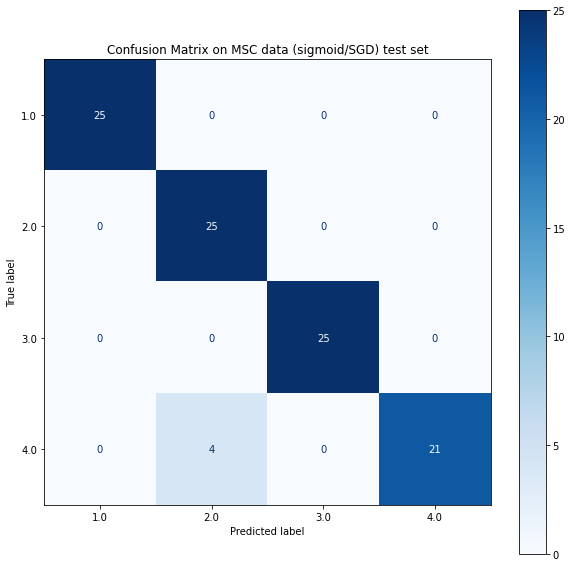

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4/4 [==============================] - 0s 1ms/step


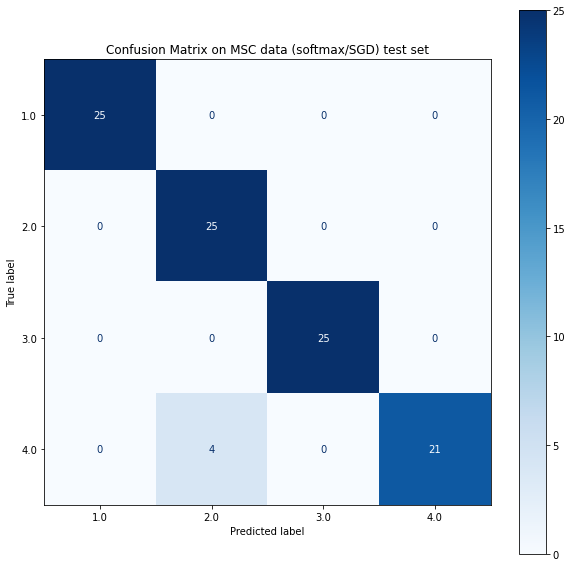

In [21]:
classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (sigmoid/SGD) test set')
# plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (softmax/SGD) test set')
# plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

## 2.2. Adam Optimizer

- BenchMark - build model

In [22]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xs_train, y_train, epochs=100, \
            validation_data=(Xs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xs_train, y_train, epochs=100, \
            validation_data=(Xs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 27ms/step - loss: 1.6592 - accuracy: 0.5502 - val_loss: 1.4150 - val_accuracy: 0.7162
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 1.2720 - accuracy: 0.8554 - val_loss: 1.1834 - val_accuracy: 0.8311
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 1.0677 - accuracy: 0.8795 - val_loss: 1.0284 - val_accuracy: 0.8176
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.9136 - accuracy: 0.9116 - val_loss: 0.8902 - val_accuracy: 0.8716
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.7818 - accuracy: 0.9277 - val_loss: 0.7675 - val_accuracy: 0.8784
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 0.6711 - accuracy: 0.9277 - val_loss: 0.6597 - val_accuracy: 0.9257
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5757 - accuracy: 0.9759 - val_loss: 0.5663 - val_accuracy: 0.9392
Epoch 8/100
8/8 [======

8/8 [==============================] - 0s 8ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 60/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 1.0000
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 62/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 1.0000
Epoch 63/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 65/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 66/100
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.1804 - accuracy: 0.9478 - val_loss: 0.2599 - val_accuracy: 0.9324
Epoch 18/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1675 - accuracy: 0.9558 - val_loss: 0.1885 - val_accuracy: 0.9459
Epoch 19/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1406 - accuracy: 0.9598 - val_loss: 0.1904 - val_accuracy: 0.9392
Epoch 20/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1050 - accuracy: 0.9679 - val_loss: 0.1766 - val_accuracy: 0.9392
Epoch 21/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1038 - accuracy: 0.9719 - val_loss: 0.1489 - val_accuracy: 0.9459
Epoch 22/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0816 - accuracy: 0.9679 - val_loss: 0.1505 - val_accuracy: 0.9392
Epoch 23/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0903 - accuracy: 0.9679 - val_loss: 0.1406 - val_accuracy: 0.9527
Epoch 24/100
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0465 - accuracy: 0.9960 - val_loss: 0.1560 - val_accuracy: 0.9595
Epoch 76/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0703 - accuracy: 0.9759 - val_loss: 0.1064 - val_accuracy: 0.9730
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0670 - accuracy: 0.9719 - val_loss: 0.0656 - val_accuracy: 0.9730
Epoch 78/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9799 - val_loss: 0.0470 - val_accuracy: 0.9797
Epoch 79/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0344 - accuracy: 0.9799 - val_loss: 0.0698 - val_accuracy: 0.9662
Epoch 80/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9960 - val_loss: 0.0734 - val_accuracy: 0.9730
Epoch 81/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0458 - val_accuracy: 0.9797
Epoch 82/100
8/8 [===============

- BenchMark - plot loss and acc

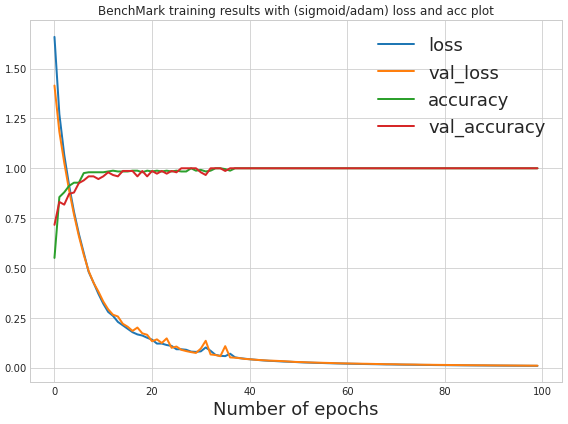

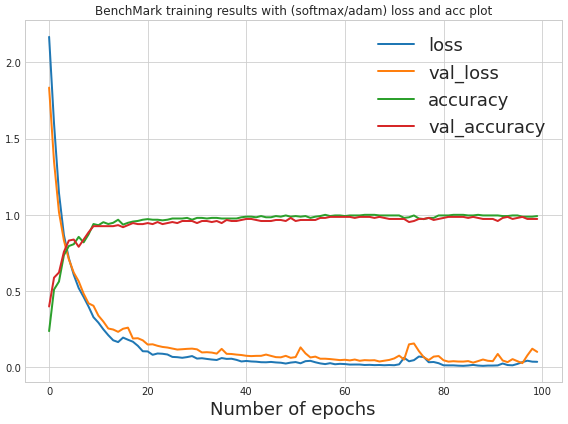

In [23]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('BenchMark training results with (sigmoid/adam) loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('BenchMark training results with (softmax/adam) loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- BenchMark - report

In [24]:
pred_train = model1.predict(Xs_train)
scores = model1.evaluate(Xs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid/adam) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xs_test)
scores2 = model1.evaluate(Xs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid/adam) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xs_train)
scores = model2.evaluate(Xs_train, y_train, verbose = 0)
print("Accuracy on (softmax/adam) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xs_test)
scores2 = model2.evaluate(Xs_test, y_test, verbose = 0)
print("Accuracy on (softmax/adam) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 1ms/step
Accuracy on (sigmoid/adam) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 2ms/step
Accuracy on (sigmoid/adam) test data: 0.949999988079071% 
 Error on test data: 0.050000011920928955
-----------------------------------------------------------------
8/8 [==============================] - 0s 2ms/step
Accuracy on (softmax/adam) train data: 0.9959839582443237% 
 Error on train data: 0.0040160417556762695
4/4 [==============================] - 0s 2ms/step
Accuracy on (softmax/adam) test data: 0.8600000143051147% 
 Error on test data: 0.13999998569488525


- BenchMark - confusion matrix

4/4 [==============================] - 0s 2ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


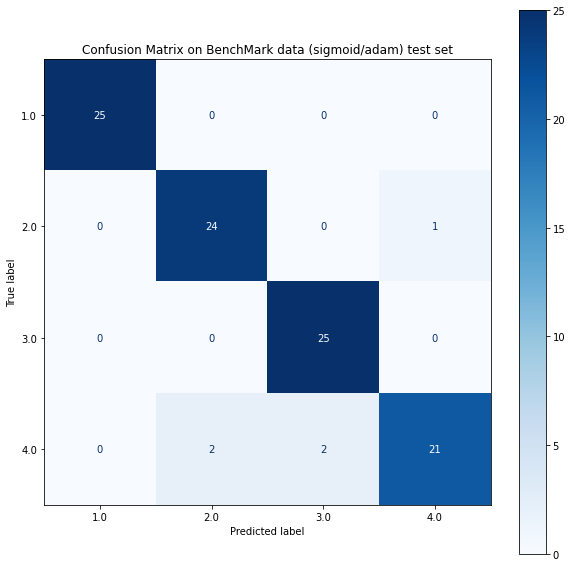

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4/4 [==============================] - 0s 1ms/step


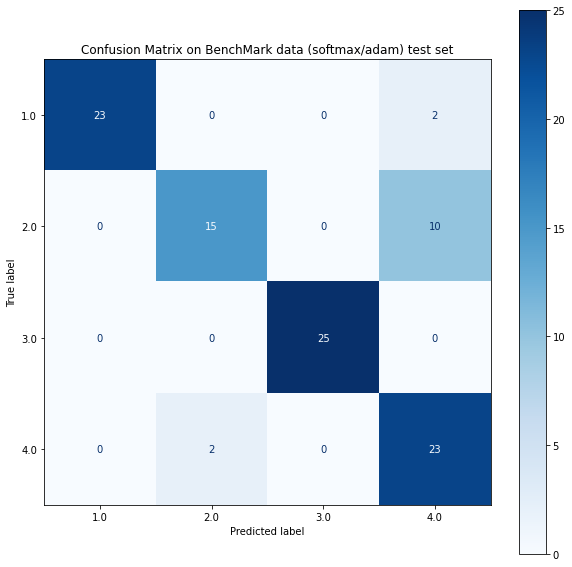

In [25]:
classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on BenchMark data (sigmoid/adam) test set')
# plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on BenchMark data (softmax/adam) test set')
# plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

- MSC - build model

In [26]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xmscs_train, y_train, epochs=100, \
            validation_data=(Xmscs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xmscs_train, y_train, epochs=100, \
            validation_data=(Xmscs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 28ms/step - loss: 1.6948 - accuracy: 0.6466 - val_loss: 1.2228 - val_accuracy: 0.8581
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 1.0890 - accuracy: 0.8755 - val_loss: 0.9908 - val_accuracy: 0.8919
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.8833 - accuracy: 0.8996 - val_loss: 0.8563 - val_accuracy: 0.8919
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.7493 - accuracy: 0.9076 - val_loss: 0.7536 - val_accuracy: 0.8919
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.6439 - accuracy: 0.9197 - val_loss: 0.6588 - val_accuracy: 0.8851
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.5504 - accuracy: 0.9277 - val_loss: 0.5673 - val_accuracy: 0.8851
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 0.4689 - accuracy: 0.9277 - val_loss: 0.4778 - val_accuracy: 0.8986
Epoch 8/100
8/8 [====

8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.1134 - val_accuracy: 0.9730
Epoch 60/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.1131 - val_accuracy: 0.9730
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.1124 - val_accuracy: 0.9730
Epoch 62/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.1134 - val_accuracy: 0.9730
Epoch 63/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.1161 - val_accuracy: 0.9730
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.1136 - val_accuracy: 0.9730
Epoch 65/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.1135 - val_accuracy: 0.9730
Epoch 66/100
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 18/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 19/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 20/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 21/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 22/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 23/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 24/100
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 1.1002e-04 - accuracy: 1.0000 - val_loss: 5.7118e-04 - val_accuracy: 1.0000
Epoch 74/100
8/8 [==============================] - 0s 8ms/step - loss: 1.0673e-04 - accuracy: 1.0000 - val_loss: 5.7285e-04 - val_accuracy: 1.0000
Epoch 75/100
8/8 [==============================] - 0s 7ms/step - loss: 1.0331e-04 - accuracy: 1.0000 - val_loss: 5.6470e-04 - val_accuracy: 1.0000
Epoch 76/100
8/8 [==============================] - 0s 8ms/step - loss: 1.0028e-04 - accuracy: 1.0000 - val_loss: 5.5773e-04 - val_accuracy: 1.0000
Epoch 77/100
8/8 [==============================] - 0s 8ms/step - loss: 9.7357e-05 - accuracy: 1.0000 - val_loss: 5.5145e-04 - val_accuracy: 1.0000
Epoch 78/100
8/8 [==============================] - 0s 8ms/step - loss: 9.4541e-05 - accuracy: 1.0000 - val_loss: 5.4596e-04 - val_accuracy: 1.0000
Epoch 79/100
8/8 [==============================] - 0s 8ms/step - loss: 9.1600e-05 - accuracy: 1.0000 - val_loss: 5.4353e-04 

- MSC - plot loss and acc

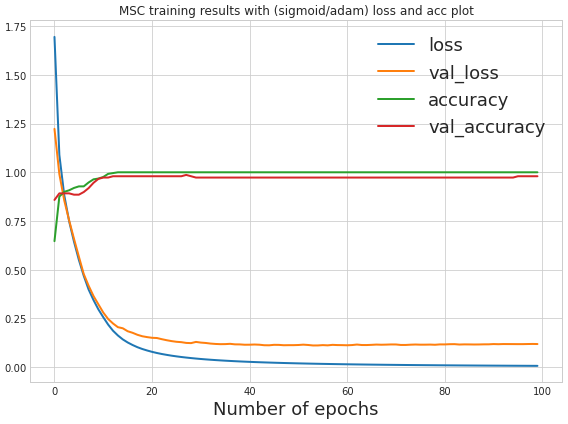

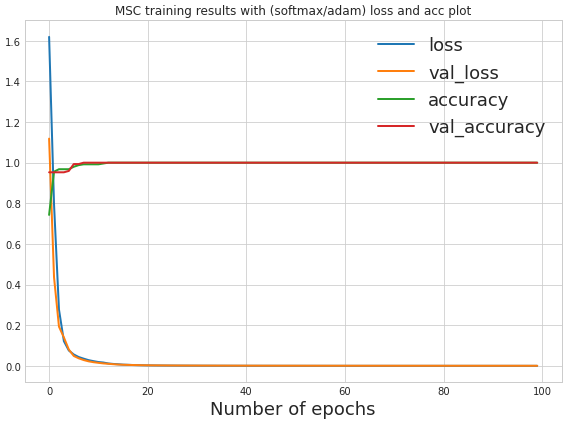

In [27]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('MSC training results with (sigmoid/adam) loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('MSC training results with (softmax/adam) loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- MSC - report

In [28]:
pred_train = model1.predict(Xmscs_train)
scores = model1.evaluate(Xmscs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid/adam) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xmscs_test)
scores2 = model1.evaluate(Xmscs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid/adam) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xmscs_train)
scores = model2.evaluate(Xmscs_train, y_train, verbose = 0)
print("Accuracy on (softmax/adam) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xmscs_test)
scores2 = model2.evaluate(Xmscs_test, y_test, verbose = 0)
print("Accuracy on (softmax/adam) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 2ms/step
Accuracy on (sigmoid/adam) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 1ms/step
Accuracy on (sigmoid/adam) test data: 0.9300000071525574% 
 Error on test data: 0.06999999284744263
-----------------------------------------------------------------
8/8 [==============================] - 0s 1ms/step
Accuracy on (softmax/adam) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 1ms/step
Accuracy on (softmax/adam) test data: 0.9700000286102295% 
 Error on test data: 0.029999971389770508


- MSC - confusion matrix

4/4 [==============================] - 0s 1ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


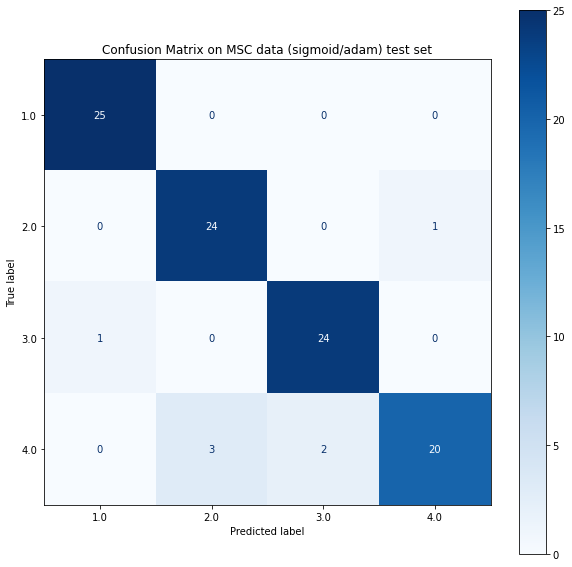

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4/4 [==============================] - 0s 2ms/step


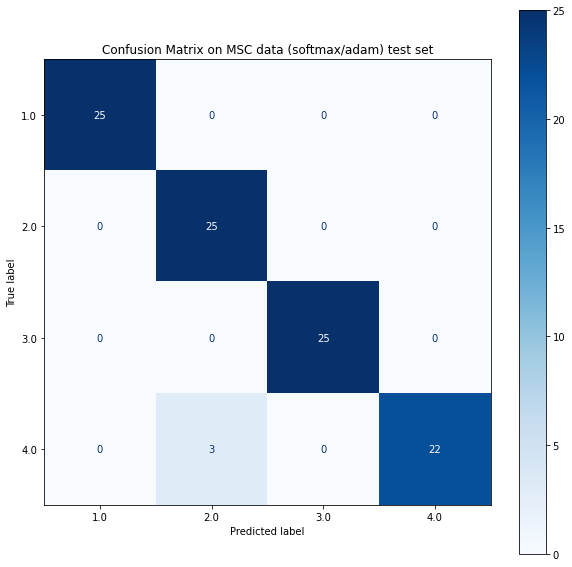

In [29]:
classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (sigmoid/adam) test set')
# plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (softmax/adam) test set')
# plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xmscs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

- SNV - build model

In [30]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history1 = model1.fit(Xsnvs_train, y_train, epochs=100, \
            validation_data=(Xsnvs_validation, y_validation), \
            verbose=1)
history2 = model2.fit(Xsnvs_train, y_train, epochs=100, \
            validation_data=(Xsnvs_validation, y_validation), \
            verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 27ms/step - loss: 1.4761 - accuracy: 0.6948 - val_loss: 0.8820 - val_accuracy: 0.9392
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.7191 - accuracy: 0.9639 - val_loss: 0.5948 - val_accuracy: 0.9662
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.5229 - accuracy: 0.9839 - val_loss: 0.4657 - val_accuracy: 0.9797
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.4121 - accuracy: 0.9880 - val_loss: 0.3705 - val_accuracy: 0.9865
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.3417 - accuracy: 0.9880 - val_loss: 0.3112 - val_accuracy: 0.9865
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.2896 - accuracy: 0.9880 - val_loss: 0.2616 - val_accuracy: 0.9932
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.2517 - accuracy: 0.9880 - val_loss: 0.2280 - val_accuracy: 0.9932
Epoch 8/100
8/8 [=======

8/8 [==============================] - 0s 7ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 60/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 61/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 62/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 63/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 1.0000
Epoch 64/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 65/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 66/100
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 18/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 19/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 20/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 21/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 8.7206e-04 - val_accuracy: 1.0000
Epoch 22/100
8/8 [==============================] - 0s 8ms/step - loss: 9.3100e-04 - accuracy: 1.0000 - val_loss: 7.7128e-04 - val_accuracy: 1.0000
Epoch 23/100
8/8 [==============================] - 0s 7ms/step - loss: 8.5815e-04 - accuracy: 1.0000 - val_loss: 6.9981e-04 - val_accuracy: 1.0000
Epoch 24/100


Epoch 73/100
8/8 [==============================] - 0s 8ms/step - loss: 5.7035e-05 - accuracy: 1.0000 - val_loss: 5.5044e-05 - val_accuracy: 1.0000
Epoch 74/100
8/8 [==============================] - 0s 8ms/step - loss: 5.5413e-05 - accuracy: 1.0000 - val_loss: 5.3134e-05 - val_accuracy: 1.0000
Epoch 75/100
8/8 [==============================] - 0s 8ms/step - loss: 5.3654e-05 - accuracy: 1.0000 - val_loss: 5.1617e-05 - val_accuracy: 1.0000
Epoch 76/100
8/8 [==============================] - 0s 8ms/step - loss: 5.2271e-05 - accuracy: 1.0000 - val_loss: 5.0414e-05 - val_accuracy: 1.0000
Epoch 77/100
8/8 [==============================] - 0s 7ms/step - loss: 5.1031e-05 - accuracy: 1.0000 - val_loss: 4.9122e-05 - val_accuracy: 1.0000
Epoch 78/100
8/8 [==============================] - 0s 8ms/step - loss: 4.9443e-05 - accuracy: 1.0000 - val_loss: 4.7759e-05 - val_accuracy: 1.0000
Epoch 79/100
8/8 [==============================] - 0s 8ms/step - loss: 4.8192e-05 - accuracy: 1.0000 - val_loss

- SNV - plot loss and acc

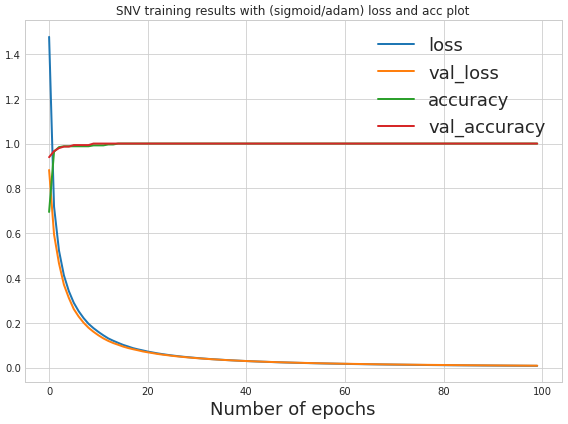

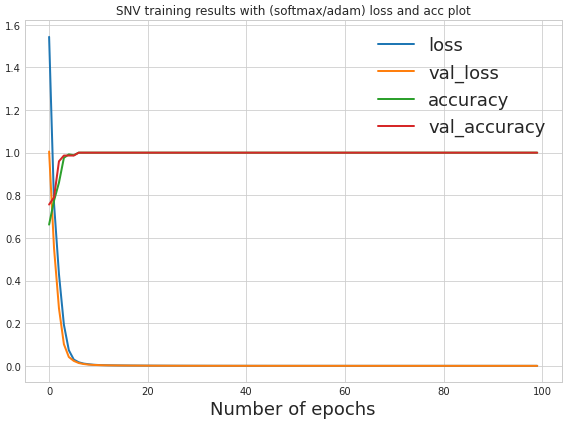

In [31]:
with plt.style.context(('seaborn-whitegrid')):
    fig, ax = plt.subplots(figsize=(8, 6))
 
    ax.plot(history1.history['loss'], linewidth=2, label='loss')
    ax.plot(history1.history['val_loss'], linewidth=2, label='val_loss')
    ax.plot(history1.history['accuracy'], linewidth=2, label='accuracy')
    ax.plot(history1.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('SNV training results with (sigmoid/adam) loss and acc plot')
    ax.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

with plt.style.context(('seaborn-whitegrid')):
    fig, bx = plt.subplots(figsize=(8, 6))
 
    bx.plot(history2.history['loss'], linewidth=2, label='loss')
    bx.plot(history2.history['val_loss'], linewidth=2, label='val_loss')
    bx.plot(history2.history['accuracy'], linewidth=2, label='accuracy')
    bx.plot(history2.history['val_accuracy'], linewidth=2, label='val_accuracy')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('SNV training results with (softmax/adam) loss and acc plot')
    bx.set_xlabel('Number of epochs',fontsize=18)
    plt.legend(fontsize=18)
 
    plt.tight_layout()
plt.show()

- SNV - report

In [32]:
pred_train = model1.predict(Xsnvs_train)
scores = model1.evaluate(Xsnvs_train, y_train, verbose = 0)
print("Accuracy on (sigmoid/adam) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model1.predict(Xsnvs_test)
scores2 = model1.evaluate(Xsnvs_test, y_test, verbose = 0)
print("Accuracy on (sigmoid/adam) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

print('-----------------------------------------------------------------')

pred_train = model2.predict(Xsnvs_train)
scores = model2.evaluate(Xsnvs_train, y_train, verbose = 0)
print("Accuracy on (softmax/adam) train data: {}% \n Error on train data: {}".format(scores[1],1-scores[1]))

pred_test = model2.predict(Xsnvs_test)
scores2 = model2.evaluate(Xsnvs_test, y_test, verbose = 0)
print("Accuracy on (softmax/adam) test data: {}% \n Error on test data: {}".format(scores2[1],1-scores2[1]))

8/8 [==============================] - 0s 2ms/step
Accuracy on (sigmoid/adam) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 2ms/step
Accuracy on (sigmoid/adam) test data: 0.949999988079071% 
 Error on test data: 0.050000011920928955
-----------------------------------------------------------------
8/8 [==============================] - 0s 1ms/step
Accuracy on (softmax/adam) train data: 1.0% 
 Error on train data: 0.0
4/4 [==============================] - 0s 2ms/step
Accuracy on (softmax/adam) test data: 0.9599999785423279% 
 Error on test data: 0.04000002145767212


- SNV - confusion matrix

4/4 [==============================] - 0s 2ms/step


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


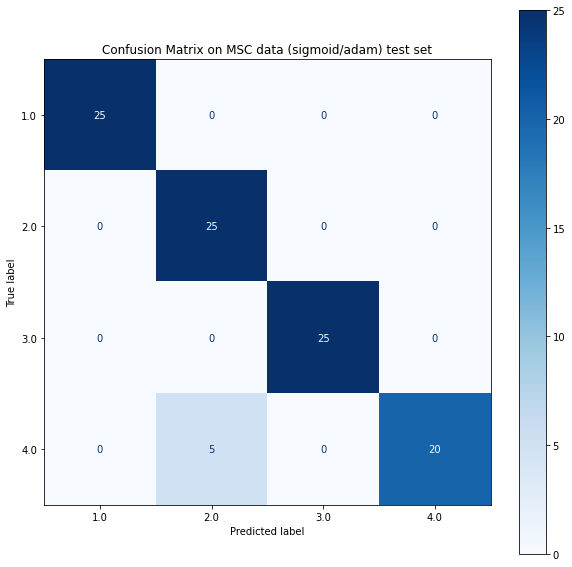

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


4/4 [==============================] - 0s 1ms/step


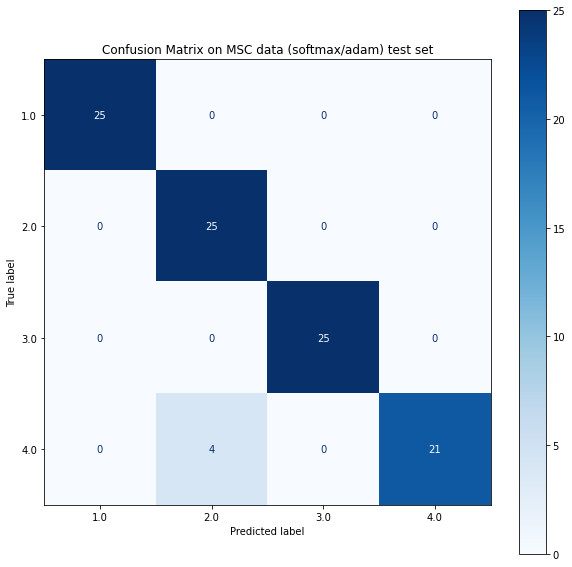

In [33]:
classifier = estimator(model1, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (sigmoid/adam) test set')
# plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()

classifier = estimator(model2, y_train_class)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('Confusion Matrix on MSC data (softmax/adam) test set')
# plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax, normalize='true')
plot_confusion_matrix(estimator=classifier, X=Xsnvs_test, y_true=y_test, cmap = plt.cm.Blues, ax = ax)
plt.show()